In [1]:
# load in all the modules we're going to need
import nltk, re, string, collections
import pandas as pd
from nltk.util import ngrams # function for making ngrams

#Import seaborn for data exploration
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
sns.set(style="darkgrid")
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize

import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\c5250435\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_bjp=pd.read_csv('BJP_Clean_Tweets.csv')
df_congress=pd.read_csv('Congress_Clean_Tweets.csv')
df_bjp.head()

,Unnamed: 0,Created At,Likes,Location,Name,Retweet,Tweet,Tweet_cleaned,_id,id,party,hashtags
0,0,2019-03-28 09:38:37,0,banka,sudhanshu kumar das,0,RT @theskindoctor13: @ANI Shatrughan Sinha ke ...,ANI Shatrughan Sinha ke Congress me aane se ji...,5c9c96235c284c72c0f92f17,1111200911781564416,bjp,[]
1,1,2019-03-28 09:38:37,0,"Lucknow, India",Ayush Sfi,0,RT @YsakMv: CPI(M) Manifesto 2019 Release. M...,CPI M Manifesto 2019 Release Main Slogans Defe...,5c9c96245c284c72c0f92f18,1111200912255537152,bjp,[]
2,2,2019-03-28 09:38:37,0,"New Delhi, India",godi_media,0,RT @AisiTaisiDemo: Kuchh bhi mat bolo @abhisar...,Kuchh bhi mat bolo abhisar sharma Uss akhbaar ...,5c9c96255c284c72c0f92f19,1111200913014820864,bjp,[]
3,3,2019-03-28 09:38:38,0,अंतरिक्ष - स्वर्ग में😍,ॐ प्रियाशा चतुर्वेदी🇮🇳,0,RT @__kashyap__: #JayaPrada joins BJP. So BJP'...,#JayaPrada joins BJP So BJP s slogan is comple...,5c9c96265c284c72c0f92f1a,1111200915862614016,bjp,"['JayaPrada', 'BJPVijaySankalp', 'NamoAgain']"
4,4,2019-03-28 09:38:38,0,NaN,Chowkidar SAI,0,RT @rajnathsingh: Had a wonderful interaction ...,Had a wonderful interaction with BJP activists...,5c9c96275c284c72c0f92f1b,1111200916655341568,bjp,[]


In [3]:
texts_b=df_bjp['Tweet_cleaned']
texts_c=df_congress['Tweet_cleaned']
texts_c[800:805].values

array(['To all Muslimah happy #MuslimWomenDay In honor of the 2nd anniversary of #MuslimWomenDay I celebrate trailblazers Tlaib amp',
       'AmitShah SwamiGeetika BJP4India BJP4Assam Congress is playing dangerous politics in Tripura by provoking indigenous peoples against local Bengali people This should be addressed properly sir for peace and prosperity of this region AmitShah narendramodi BjpBiplab',
       'We have to VET every single candidate and person of position FOREVER We may never be rid of this regime',
       'BJP4India gssjodhpur 50 60 saal congress ko diye Lagbhag lagatar Ab bjp ko bhi seva ka moka milna cahiye na 50 60 sall',
       'In 1977 when a coalition of right wing parties accused Pakistan s then PM Zulfiqar Bhutto of being a drunk his response was Haan mein #sharaab peeta hoon lekin awam ka khoon nahi peeta Yes I drink but I do not drink the people s blood'],
      dtype=object)

In [4]:
#Handling stopwords
stopwrd = set(stopwords.words('english'))
#stopwrd.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}','bjp','priyankac19','bjp','congress','jhasanjay']) # remove it if you need punctuation 
stopwrd.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) 
texts_bjp=[]
for sentence in texts_b:
    texts_bjp.append([i for i in sentence.lower().split() if i not in stopwrd])
texts_congress=[]
for sentence in texts_c:
    texts_congress.append([i for i in sentence.lower().split() if i not in stopwrd])
texts_bjp[2:3]

[['kuchh',
  'bhi',
  'mat',
  'bolo',
  'abhisar',
  'sharma',
  'uss',
  'akhbaar',
  'ke',
  'tukde',
  'mein',
  'nano',
  'chip',
  'laga',
  'hai',
  'jo',
  '2000',
  'rupaye',
  'ke',
  'note',
  'waale',
  'nano',
  'chip']]

In [5]:
texts_wo_stpwrds_bjp=pd.Series(texts_bjp).apply(lambda x:' '.join(x))
#texts_wo_stpwrds_bjp
texts_wo_stpwrds_congress=pd.Series(texts_congress).apply(lambda x:' '.join(x))
texts_wo_stpwrds_congress[119:124]

119    india envisioned mahatma gandhi pandit jawahar...
120    arunjaitley 20 30 yrs enough develop nation lo...
121    tax raids karnataka corrupt engineers contract...
122    right bipartisan bill senate would require ful...
123    unacceptable shameful counterproductive media ...
dtype: object

## N-gram Model
##### The most popular bag-of words in NLP has n-gram models comprising of 1 -word text (Unigram) , 2-word text (Bi-gram) , 3-gram text (Tri-gram), where the number of occurrences of single word, side-by-side 2 words, side-by-side 3 words are counted and fed as feature-vectors to Text Classifiers (Naive Bayes, Maxium Entropy and Support Vector Machines). Word occurrences are counted after cleaning the tweets from hashtags, urls, emojis stopwords and character repeatations. This helps to extract most popular 1-word, 2-words, 3-words from tweet and construct feature vectors to determine the overall sentiment score of the text.

##### Looking at the tweets, it seems apart from a few typos, nothing much can be modified at this point of time

In [6]:
def get_ngrams(text,n=3):
    # first get individual words
    token = text.split()
    #print(tokenized)
    # and get a list of all the bi-grams
   
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [7]:
def return_list_ngrams(data,n):
    trigrams=[get_ngrams(text,n) for text in data]
    #Flatten the 2layered list of ngrams
    merged = list(itertools.chain(*trigrams))
    return merged

['bjp alliance increase', 'alliance increase strength', 'increase strength cpi']


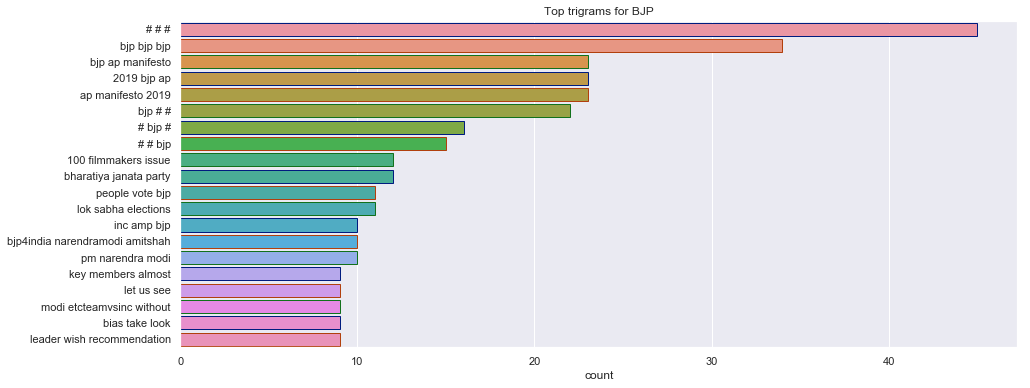

In [8]:
list_ngrams_bjp=return_list_ngrams(texts_wo_stpwrds_bjp,n=3)
print(list_ngrams_bjp[25:28])
#Plot the graph
plt.figure(figsize=(15,6))
sns.countplot(y = list_ngrams_bjp,
              order = pd.Series(list_ngrams_bjp).value_counts().iloc[:20].index,
              edgecolor=sns.color_palette("dark", 3)).set_title('Top trigrams for BJP')
plt.show()
#df_bjp_clean_tweets['Location'].value_counts()

['dar bhatakne ke', 'bhatakne ke baad', 'ke baad bhi']


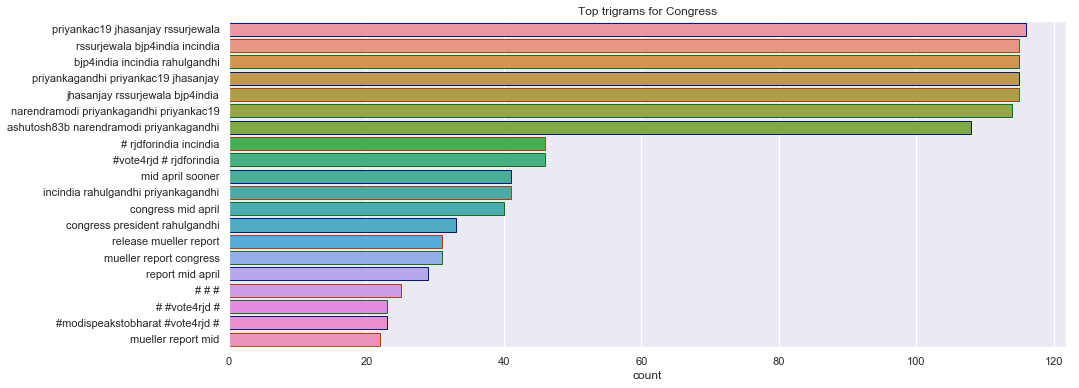

In [9]:
list_trigrams_congress=return_list_ngrams(texts_wo_stpwrds_congress,n=3)
print(list_trigrams_congress[225:228])
#Plot the graph
plt.figure(figsize=(15,6))
sns.countplot(y = list_trigrams_congress,
              order = pd.Series(list_trigrams_congress).value_counts().iloc[:20].index,
              edgecolor=sns.color_palette("dark", 3)).set_title('Top trigrams for Congress')
plt.show()
#df_bjp_clean_tweets['Location'].value_counts()

['defeat bjp', 'bjp alliance', 'alliance increase']


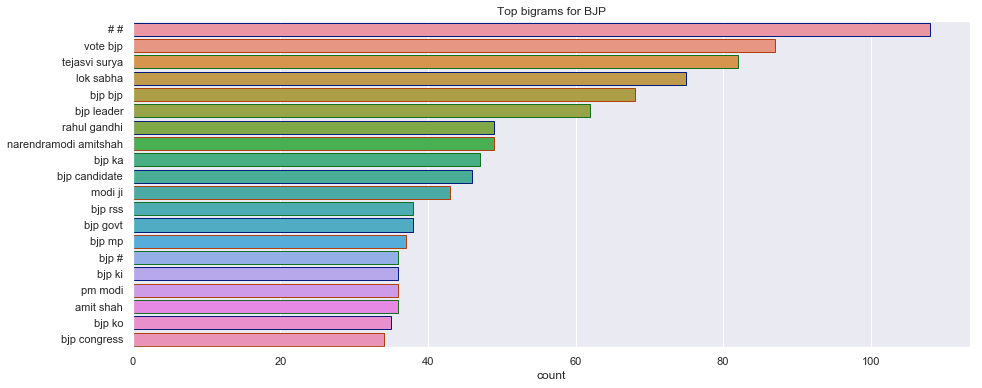

In [11]:
list_bigrams_bjp=return_list_ngrams(texts_wo_stpwrds_bjp,n=2)
print(list_bigrams_bjp[25:28])
#Plot the graph
plt.figure(figsize=(15,6))
sns.countplot(y = list_bigrams_bjp,
              order = pd.Series(list_bigrams_bjp).value_counts().iloc[:20].index,
              edgecolor=sns.color_palette("dark", 3)).set_title('Top bigrams for BJP')
plt.show()
#df_bjp_clean_tweets['Location'].value_counts()

['opindia com', 'com frustindian', 'frustindian sudhirchaudhary']


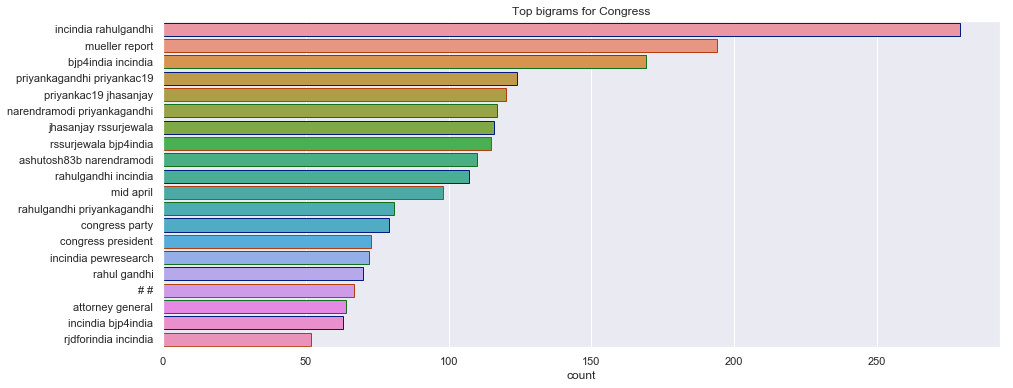

In [10]:
list_bigrams_congress=return_list_ngrams(texts_wo_stpwrds_congress,n=2)
print(list_bigrams_congress[2525:2528])
#Plot the graph
plt.figure(figsize=(15,6))
sns.countplot(y = list_bigrams_congress,
              order = pd.Series(list_bigrams_congress).value_counts().iloc[:20].index,
              edgecolor=sns.color_palette("dark", 3)).set_title('Top bigrams for Congress')
plt.show()
#df_bjp_clean_tweets['Location'].value_counts()